In [1]:
using PyPlot, JLD, AnomalyDetection, EvalCurves
import PyPlot: plot
include("./plots.jl")

PyPlot.plot

In [2]:
# load data
dataset = load("toy_data_3.jld")["data"]
#dataset = load("moon.jld")["data"]
X = AnomalyDetection.Float.(dataset.data)
Y = dataset.labels
nX = X[:, Y.==0]

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [3]:
# VAE settings
indim = size(X,1)
hiddendim = 10
latentdim = 2
nlayers = 2

# setup the VAE object
variant = :sigma
    # :unit - output has unit variance
    # :sigma - the variance of the output is estimated
esize = [indim; hiddendim; hiddendim; latentdim*2] # encoder architecture
# decoder architecture
(variant == :unit)? dsize = [latentdim; hiddendim; hiddendim; indim] :
    dsize = [latentdim; hiddendim; hiddendim; 2*indim]
lambda = 1e-3 # KLD weight in loss function
threshold = 0 # classification threshold, is recomputed using setthreshold!()
contamination = size(Y[Y.==1],1)/size(Y, 1) # for automatic threshold computation
iterations = 2000
cbit = 500 # after this number of iteratiosn, callback is printed
verbfit = true
M = 1 # reconstruction error samples, for training 1 is OK
batchsize = 50 # batchsize 
# set low for training but high for classification
activation = Flux.relu
layer = Flux.Dense
rdelta = Inf # reconstruction error threshold for training stopping
Beta = 1.0 # for automatic threshold computation, in [0, 1] 
# 1.0 = tight around normal samples
tracked = true # do you want to store training progress?
# it can be later retrieved from model.traindata
eta = 0.001
model = VAEmodel(esize, dsize, lambda = lambda, threshold = threshold, 
    contamination = contamination, iterations = iterations, cbit = cbit, 
    verbfit = verbfit, batchsize = batchsize, M=M, activation = activation, layer = layer, rdelta = rdelta, Beta = Beta, 
    tracked = tracked, variant = variant, eta = eta)

AnomalyDetection.VAEmodel(AnomalyDetection.VAE{Flux.Chain,AnomalyDetection.#samplenormal,Flux.Chain,Val{:sigma}}(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 4)), AnomalyDetection.samplenormal, Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu), Dense(10, 4)), Val{:sigma}()), 0.001, 0, 0.1262135922330097, 2000, 500, true, 50, 1, Inf32, 1.0f0, MVHistory{ValueHistories.History}, "likelihood", 0.001)

In [4]:
# fit the model
println("\ninitial loss")
AnomalyDetection.evalloss(model, nX)
@time AnomalyDetection.fit!(model, nX)
println("\nfinal loss")
AnomalyDetection.evalloss(model, nX)
AnomalyDetection.setthreshold!(model, X)


initial loss
loss: 0.49407744
likelihood: 0.5168791
KL: 0.22683439



Progress:   0%|                                         |  ETA: 1:07:49
  loss:        0.44866514
  likelihood:  0.5111562
Progress:  11%|█████                                    |  ETA: 0:00:22
  loss:        0.44866514
  likelihood:  0.5111562
Progress:  19%|████████                                 |  ETA: 0:00:13
  loss:        0.44866514
  likelihood:  0.5111562
Progress:  28%|███████████                              |  ETA: 0:00:09
  loss:        -4.407604
  likelihood:  -4.77562
Progress:  36%|███████████████                          |  ETA: 0:00:07
  loss:        -4.407604
  likelihood:  -4.77562
Progress:  44%|██████████████████                       |  ETA: 0:00:05
  loss:        -4.407604
  likelihood:  -4.77562
Progress:  53%|██████████████████████                   |  ETA: 0:00:04
  loss:        -5.5033507
  likelihood:  -5.5185194
Progress:  61%|█████████████████████████                |  ETA: 0:00:03
  loss:        -5.5033507
  likelihood:  -5.5185194
Progress:  70%|█████

-2.416355f0

  7.205583 seconds (13.45 M allocations: 1.744 GiB, 3.62% gc time)

final loss
loss: -6.3961186
likelihood: -6.404104
KL: 13.425602



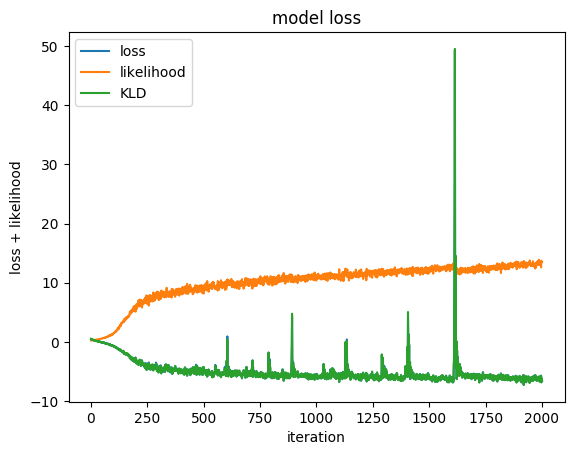

In [5]:
plot(model)
show()

How does the model reconstruct the normal data?

In [6]:
model(nX)

Tracked 4×90 Array{Float32,2}:
   0.804061    0.804528    0.807268  …   0.0619776   0.0873283   0.0766635
   0.809462    0.811764    0.815951      0.393073    0.42184     0.402095 
 -12.583     -12.6176    -12.6832       -5.63826    -6.10474    -5.69421  
  -7.49305    -7.43179    -7.38223      -1.43982    -1.67749    -1.50588  

In [7]:
nX

2×90 Array{Float32,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [8]:
AnomalyDetection.mux(model, nX)

Tracked 2×90 Array{Float32,2}:
 0.80359   0.804907  0.807223  0.819559  …  0.062474  0.0812266  0.0820556
 0.805953  0.813482  0.815635  0.822577     0.393213  0.411887   0.410996 

In [9]:
AnomalyDetection.sigma2x(model, nX)

Tracked 2×90 Array{Float32,2}:
 4.21865f-6   4.21865f-6   4.21865f-6  …  0.00390605  0.00244336  0.00283892
 0.000665848  0.000600086  0.00057733     0.221251    0.177692    0.18722   

What are the parameters of $q(z|x)$?

In [10]:
AnomalyDetection.muz(model, nX)

Tracked 2×90 Array{Float32,2}:
 -0.172737  -0.196353  -0.169095  …  -3.1881    -3.16349   -3.06932 
  4.5239     4.5306     4.54246       0.759051   0.893309   0.923729

In [11]:
AnomalyDetection.sigma2z(model, nX)

Tracked 2×90 Array{Float32,2}:
 0.0275031   0.0267041   0.0272719   …  0.0136208   0.012788    0.0138525 
 4.09944f-6  3.86102f-6  3.98023f-6     8.27742f-5  6.19141f-5  6.99006f-5

What do the codes look like?

In [12]:
AnomalyDetection.sample_z(model, nX)

Tracked 2×90 Array{Float32,2}:
 -0.0352585  -0.438731  -0.10906  …  -3.21072   -3.1138    -3.15068 
  4.52751     4.5294     4.54037      0.758034   0.896419   0.927355

In [13]:
# predict labels on testing data
model.M = 10 # for classification higher is better (more stable)
tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 0
 1
 1
 1
 1
 1
 1
 1
 1

In [14]:
# get the labels and roc stats
tryhat, tstyhat = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 11
  tn = 88
  fp = 2
  fn = 2
precision: 0.8461538461538461
f1score: 0.8461538461538461
recall: 0.8461538461538461
false positive rate: 0.022222222222222223
equal error rate: 0.08803418803418804


In [15]:
# anomaly score contour plot
# get limits of the figure
xl = (minimum(X[1,:])-0.05, maximum(X[1,:]) + 0.05)
yl = (minimum(X[2,:])-0.05, maximum(X[2,:]) + 0.05)

# compute the anomaly score on a grid
x = linspace(xl[1], xl[2], 30)
y = linspace(yl[1], yl[2], 30)
zz = zeros(size(y,1),size(x,1))
for i in 1:size(y, 1)
    for j in 1:size(x, 1)
        zz[i,j] = AnomalyDetection.anomalyscore(model, AnomalyDetection.Float.([x[j], y[i]]))
    end
end

# also generate some samples
xgen = AnomalyDetection.generate(model, 30);


 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 11
  tn = 88
  fp = 2
  fn = 2
precision: 0.8461538461538461
f1score: 0.8461538461538461
recall: 0.8461538461538461
false positive rate: 0.022222222222222223
equal error rate: 0.08803418803418804


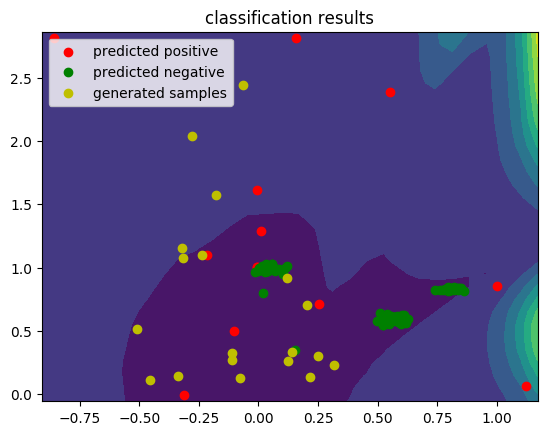

In [16]:
# plot it all
f = figure()
contourf(x, y, zz)
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r", 
    label = "predicted positive")
scatter(X[1, tryhat.==0], X[2, tryhat.==0], c = "g", 
    label = "predicted negative")
scatter(xgen[1,:], xgen[2, :], c = "y", 
    label = "generated samples")
title("classification results")
xlim(xl)
ylim(yl)
legend()
show()

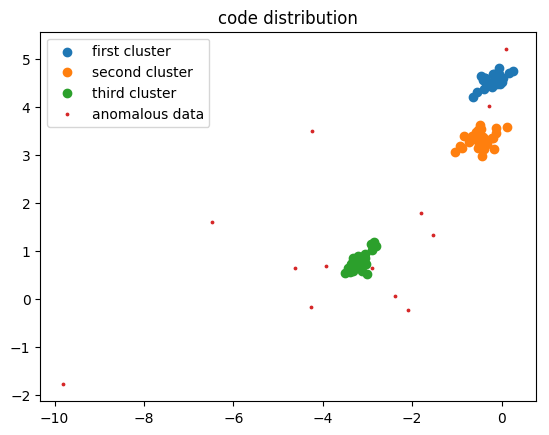

In [17]:
# what are the codes?
z1 = AnomalyDetection.getcode(model, X[:,1:30]).data
z2 = AnomalyDetection.getcode(model, X[:,31:60]).data
z3 = AnomalyDetection.getcode(model, X[:,61:90]).data
za = AnomalyDetection.getcode(model, X[:,91:end]).data

figure()
title("code distribution")
scatter(z1[1,:], z1[2,:], label = "first cluster")
scatter(z2[1,:], z2[2,:], label = "second cluster")
scatter(z3[1,:], z3[2,:], label = "third cluster")
scatter(za[1,:], za[2,:], s = 3, label = "anomalous data")
legend()
show()

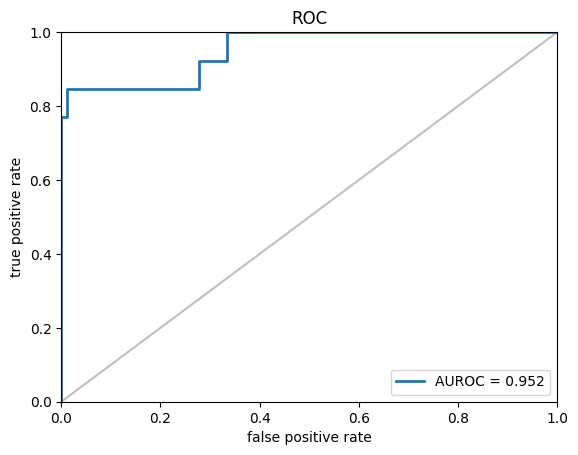

In [18]:
# plot ROC curve and compute AUROC score
ascore = AnomalyDetection.anomalyscore(model, X);
fprvec, tprvec = EvalCurves.roccurve(ascore, Y)
auroc = round(EvalCurves.auc(fprvec, tprvec),3)
EvalCurves.plotroc((fprvec, tprvec, "AUROC = $(auroc)"))
show()